In [36]:
using Pkg

In [37]:
Pkg.activate(dirname(pwd()))

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`


In [38]:
using ComputationalHeatTransfer
using LaTeXStrings
using JLD2
using Plots
plotly()  

Plots.PlotlyBackend()

## Get fluid properties

In [39]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

## Read data

In [40]:
using JLD2

In [41]:
pwd()

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks"

In [125]:
# OHPdata = load("/Users/yuxuanli/Documents/OHPnume/Ca13E05_DT2/ASETS-II OHP 1 LARGE HEATER_40W.jld2")
OHPdata = load("/Users/yuxuanli/Documents/Hoffman/ohp22/OHPnume/ASETS-II OHP 2 LARGE HEATER_30W.jld2")
power = 30


┌ Warning: read type ODESolution{Float64,2,Vector{Vector{Float64}},Nothing,Nothing,Vector{Float64},Vector{Vector{Vector{Float64}}},ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, PHPSystem, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem},RK4,OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.RK4ConstantCache},DiffEqBa

30

In [111]:
#     power = 20
#     OHPdata = load(dirname(dirname(dirname(pwd())))*"/OHPnume/d1.5e-3/"*namei);
    
    ohp = OHPdata["ohp"]
    boil_data = OHPdata["boil_data"]
    tube_hist_t = OHPdata["tube_hist_t"]
    tube_hist_θwall = OHPdata["tube_hist_θwall"]
    tube_hist_u = OHPdata["tube_hist_u"]
    integrator_tube = OHPdata["integrator_tube"]
    sysfinal = getsysfinal(tube_hist_u,tube_hist_θwall,integrator_tube);

    plate_T_hist = OHPdata["plate_T_hist"]

    integrator_plate = OHPdata["integrator_plate"]
    sys = integrator_plate.p
    
    
    x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
    X =  VectorData(x,y);
    H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
    g = ScalarData(X);
    ghist = getghist(g,H,plate_T_hist);
    thist = tube_hist_t;

## Get RTD result for OHP

In [112]:
import XLSX

In [113]:
# xf = XLSX.readxlsx("20190613_F_PD_#004_O001_H001_P040_expA.xlsx")
# starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
# RTDt = (1:size(RTD,1)) .+ starti;

In [114]:
    "20190607_F_PD_%23013_O001_H002_P010_expA.xlsx";
    "20190608_F_PD_%23014_O001_H002_P020_expA.xlsx";
    "20190614_F_PD_%23015_O001_H002_P030_expA.xlsx";
    "20190617_F_PD_%23016_O001_H002_P040_expA.xlsx";
    "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";
    "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx";
    "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx";
    "20190607_F_PD_%23017_O002_H002_P010_expA.xlsx";
    "20190608_F_PD_%23018_O002_H002_P020_expA.xlsx";
    "20190614_F_PD_%23019_O002_H002_P030_expA.xlsx";
    "20190617_F_PD_%23020_O002_H002_P040_expA.xlsx";
    "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx";
    "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx";
    "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx";
    "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx";

In [115]:
# namei = "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx"
# namei = "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx"
namei = "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx"
# namei = "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx"
# namei = "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx"
# namei = "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx"
# namei =     "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
#  namei =    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";

xf = XLSX.readxlsx(dirname(dirname(dirname(pwd())))*"/OHPexp/"*namei)
    Onum, Hnum, power_exp = getconfig(namei)
    RTD,RTDt = getRTD(xf,Onum);

## boiling frequency

In [116]:
Xstations = sysfinal[end].wall.Xstations;
tend = boil_data[end,2]
boil_dt = 0.1;

In [117]:
using SparseArrays 

In [118]:
boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])

    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end


In [119]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);
t_boil = boil_dt:boil_dt:boil_dt*length(boil_num_t)

0.1:0.1:200.0

In [120]:
using EasyFit
m10 = movavg(vec(boil_num_t),10);

## Contour graphs

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif")
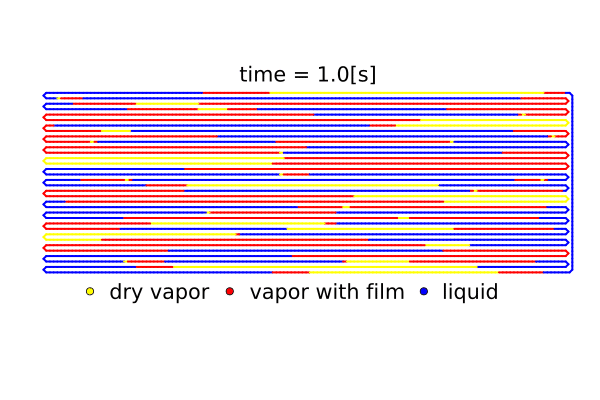

In [121]:
gr()
Hₗ = sysfinal[1].liquid.Hₗ
adjust = 1e-2;

anim = @animate for i=1:200
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
        annotate!(0.0, 0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false)
    scatter!([-0.066+adjust],[-0.028],color=:yellow);scatter!([-0.03+adjust],[-0.028],color=:red);scatter!([0.02+adjust],[-0.028],color=:blue);
    annotate!(-0.05+0.002+adjust, -0.028, "dry vapor", :black)
    annotate!(-0.01+0.005+adjust, -0.028, "vapor with film", :black)
    annotate!(0.03+0.002+adjust, -0.028, "liquid", :black)
end
gif(anim, "slug_fps15.gif", fps = 10)

### plate T [K]

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temperature_fps15.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/4UTBj/src/animation.jl:154


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temperature_fps15.gif")
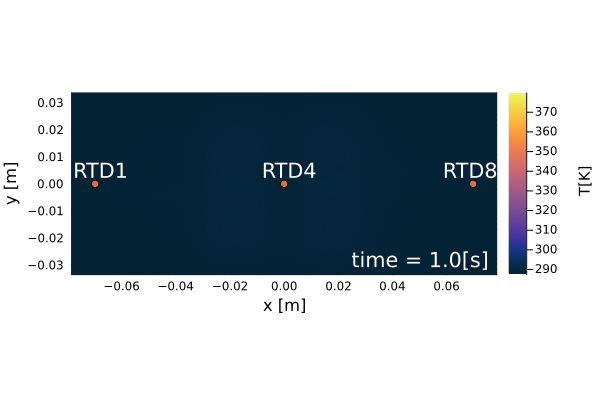

In [122]:
gr()
Tmax = maximum(plate_T_hist[end]) .- 3.8
Tmin = minimum(plate_T_hist[1]) .- 3.8
xlim = integrator_plate.p.grid.xlim[1]
ylim = integrator_plate.p.grid.xlim[2]

anim = @animate for i = 1:1:200
# @gif for i = 1:1:1
heatmap(plate_T_hist[i].- 3.8,sys.grid,legend=true,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",
        colorbar_title = "\n T[K]",right_margin = 5Plots.mm)
scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :white)
annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :white)
annotate!(x[8]-0.001, y[8]+0.005, "RTD8", :white)
annotate!(0.05, -0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white,legend=false)
end
gif(anim, "temperature_fps15.gif", fps = 10)

## temperature curve

In [52]:
Tᵥ = 291.2

291.2

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


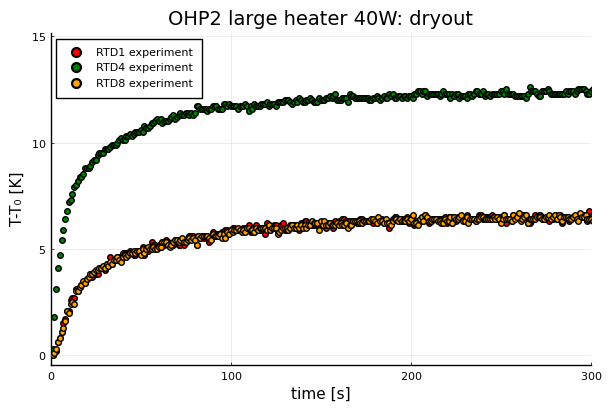

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/dryout.pdf"

In [53]:
pyplot()
i = 1 #RTD number

# p1 = plot(thist,ghist[i] .-Tᵥ, color=:red, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
p1 = scatter(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:red, label=string("RTD", i," experiment"))

i = 4 #RTD number

# plot!(thist,ghist[i] .-Tᵥ, color=:green, label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:green, label=string("RTD", i," experiment"))

i = 8 #RTD number
# plot!(thist,ghist[i] .-Tᵥ,color=:orange,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:orange, label=string("RTD", i," experiment"),
    xlabel="time [s]",ylabel="T-T₀ [K]",xlim=(0,300),title=("OHP2 large heater 40W: dryout"),legend = :topleft)

savefig(p1,"dryout.pdf")

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


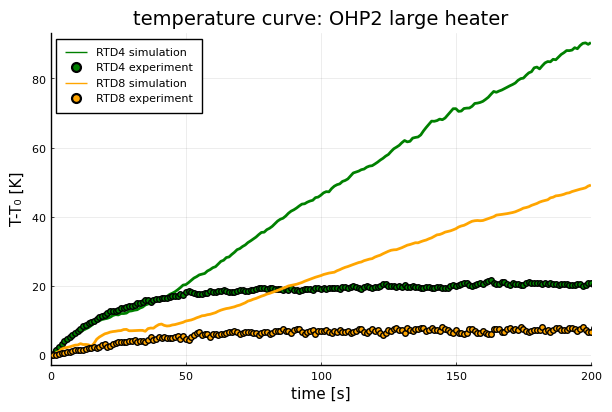

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/temp_curve.pdf"

In [123]:
pyplot()
# i = 1 #RTD number

# p1 = plot(thist,ghist[i] .-Tᵥ, color=:red, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
# scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:red, label=string("RTD", i," experiment"))

i = 4 #RTD number

p1 = plot(thist,ghist[i] .-Tᵥ, color=:green, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:green, label=string("RTD", i," experiment"))

i = 8 #RTD number
plot!(thist,ghist[i] .-Tᵥ,color=:orange,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:orange, label=string("RTD", i," experiment"),
    xlabel="time [s]",ylabel="T-T₀ [K]",xlim=(0,200),title=("temperature curve: OHP2 large heater"))

savefig(p1,"temp_curve.pdf")

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


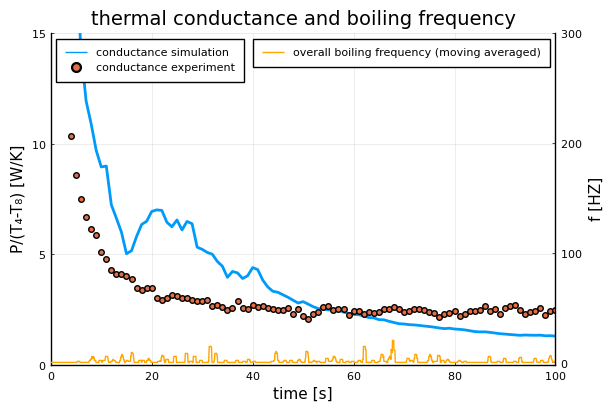

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/cond_curve.pdf"

In [124]:
pyplot()
i1 = 4 #RTD number
i2 = 8 #RTD number

p1 = plot(thist,power./(ghist[i1] .-ghist[i2]), right_margin=10Plots.mm,label=string("conductance simulation"),linewidth=2,legend=:topleft)
scatter!(RTDt .- RTDt[1],power./(RTD[:,i1] .- RTD[:,i2]), label=string("conductance experiment"),
    xlim=(0,100),ylim=(0,15),title="thermal conductance and boiling frequency",xlabel="time [s]",ylabel="P/(T₄-T₈) [W/K]")
plot!(twinx(), t_boil,m10.x./boil_dt, color=:orange, ylabel="f [HZ]",ylim=(-2,300),xlim=(0,thist[end]),label="overall boiling frequency (moving averaged)")
# plot!(right_bottom=10Plots.mm)
savefig(p1,"cond_curve.pdf")

## boilng site

In [105]:
using Interpolations

In [106]:
ql = sys.qline[1]
interp_linear_x = LinearInterpolation(ql.arccoord, ql.body.x,extrapolation_bc = Line());
interp_linear_y = LinearInterpolation(ql.arccoord, ql.body.y,extrapolation_bc = Line());

xstations = interp_linear_x[sysfinal[end].wall.Xstations]
ystations = interp_linear_y[sysfinal[end].wall.Xstations];

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


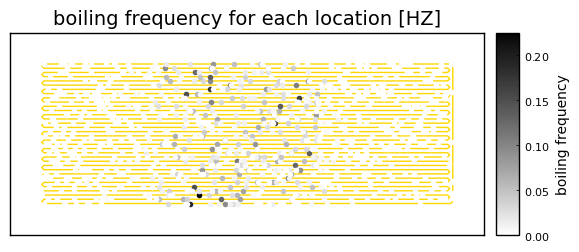

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/boilingsite.pdf"

In [107]:
ohp = sys.qline[1].body
gd = sys.grid
scatter()
plot!(ohp,fillalpha=0,xlim=gd.xlim[1],ylim=gd.xlim[2],linecolor=:gold,framestyle = :box)
scatter!(xstations,ystations,marker_z=boil_num_x[:]./tend,
    colorbar_title = "boiling frequency",markerstrokewidth=0,markercolor=cgrad(:greys, rev = true),
    axis=nothing,title="boiling frequency for each location [HZ]")

savefig("boilingsite.pdf")

## dXdt distribution

In [24]:
using Statistics

In [25]:
Vavg_hist = []
Vmax_hist = []
Vmin_hist = []
for sysi in sysfinal
    V = [elem[2] for elem in sysi.liquid.dXdt]
    Vavg = mean(abs.(V))
    Vmax = maximum((V))
    Vmin = minimum((V))
    
    push!(Vavg_hist, Vavg)
    push!(Vmax_hist, Vmax)
    push!(Vmin_hist, Vmin)
end

In [26]:
plot(thist,movavg(Float64.(Vmax_hist),10).x,label="v range",fillalpha = 0.35, c = :blue,fillrange = movavg(Float64.(Vmin_hist),10).x,fillcolor=:green)
plot!(thist,movavg(Float64.(Vavg_hist),10).x,label="|v| avg")
plot!(thist,movavg(Float64.(Vmin_hist),10).x,ylim=(-2,2),color=:blue, label=false, xlabel="t [s]", ylabel="v [m/s]",title="velocity distribution")
savefig("velocity.pdf")

LoadError: MethodError: no method matching _show(::IOStream, ::MIME{Symbol("application/pdf")}, ::Plots.Plot{Plots.PlotlyBackend})
[0mClosest candidates are:
[0m  _show(::IO, [91m::MIME{Symbol("application/vnd.plotly.v1+json")}[39m, ::Plots.Plot{Plots.PlotlyBackend}) at ~/.julia/packages/Plots/4UTBj/src/backends/plotly.jl:1101
[0m  _show(::IO, [91m::MIME{Symbol("text/html")}[39m, ::Plots.Plot{Plots.PlotlyBackend}) at ~/.julia/packages/Plots/4UTBj/src/backends/plotly.jl:1104
[0m  _show(::IO, [91m::MIME{Symbol("text/html")}[39m, ::Plots.Plot) at ~/.julia/packages/Plots/4UTBj/src/output.jl:189
[0m  ...

In [277]:
U = mean(Vavg_hist)

0.2111759753519777

## OHP film thickness correlation

In [78]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



In [ ]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [ ]:
d_tube = sysfinal[end].tube.d

### Range of Re
### $Re = \frac{\rho_{\mathrm{l}} v d}{\mu_{\mathrm{l}}}$



In [ ]:
Re_avg = d_tube*ρₗ .* velocity_avg / μₗ
Re_max = d_tube*ρₗ .* velocity_max / μₗ;

In [ ]:
plot(thist,Re_avg,label="v avg")
plot!(thist,Re_max,label="v max",xlabel="t [s]", ylabel="Re")

In [ ]:
integrator_tube.p.vapor.δ

In [ ]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca.^(2/3)) ./ ( 1 .+ 3.35 .* Ca.^(2/3))

In [ ]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca2.^(2/3)) ./ ( 1 .+ 3.35 .* Ca2.^(2/3))

In [ ]:
using UnPack

p_fluid = SaturationFluidProperty(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

In [ ]:
# U = 0.48 #m/s

Ca = U .* μₗ ./σ

In [ ]:
tube_d = 1e-3

In [ ]:
Ca_star1 = (μₗ^2/(σ * ρₗ * tube_d/2))^(3/4)

In [ ]:
Ca_star2 = (μₗ^2/(σ * ρₗ * tube_d/2))^(1/2)

In [ ]:
Ca^(2/3)/(1+Ca^(2/3)) *tube_d/2

In [ ]:
sysfinal[1].wall.ΔTthres

In [ ]:
sysfinal[1].vapor.δ

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,15,25,100]
p1 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[1]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[2]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[3]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[4]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,xticks=1e-5:2e-5:5e-5,legend=false,xlabel="δ [m]",ylabel="N of vapor",plot_title="film thickness histogram")

In [ ]:
i = 100
velocity = 
Ca = 

plot(δfilm)

In [ ]:
velocity = [elem[1] for i =1:]getCa(μ,σ,velocity)

In [ ]:
ρₗ-ρᵥ

In [ ]:
bo = (ρₗ-ρᵥ).*9.8*(1e-3)^2/σ

In [ ]:
μₗ.*1.0/σ

In [ ]:
function getCa(μ,σ,velocity)
    Ca = abs.(μ.*velocity./σ)
end

function filmδcorr(Ca,d)
    filmδ = d .* 0.67.*Ca.^(2/3)./(1 .+ 3.35.*Ca.^(2/3))
end

## Film thickness graphs

In [ ]:
@gif for i=length(sysfinal):length(sysfinal)
    plot(sysfinal[i].vapor.δ,xlabel="vapor label",ylabel="film thickness [m]", label = "δ",ylim=(5e-6,1.5e-5))
end

## boiling graph

In [ ]:
boil_data = load("OHP1_40W.jld2","boil_data");

In [ ]:
Xstations = sysfinal[end].wall.Xstations;

In [ ]:
tend = boil_data[end,2]
boil_dt = 0.1;

In [ ]:
using SparseArrays 

In [ ]:
boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])

    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end


In [ ]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);

In [ ]:
using EasyFit

m10 = movavg(vec(boil_num_t),10)


In [ ]:
m10.R

In [ ]:
plot(0.1:0.1:300.0,m10.x,xlabel="t",ylabel="N",title="number of active boiling sites (moving averaged)",legend=false)

In [ ]:
savefig("boiling frequency.pdf")

In [ ]:
boiling

In [ ]:
num_boiling = zeros(size(Xstations))
for i = 1:size(boil_data,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end
freq_boiling = num_boiling/tend;

In [ ]:
sorted_boil_hist = boil_data[sortperm(boil_data[:, 1]), :]
num_boiling = zeros(size(Xstations))
for i = 1:size(sorted_boil_hist,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end
freq_boiling = num_boiling/tend;

In [ ]:
scatter(xstations,freq_boiling,xlabel="x[m]",ylabel="boiling frequency [HZ]",legend=false)

In [ ]:
scatter(ystations,freq_boiling,xlabel="y[m]",ylabel="boiling frequency [HZ]",legend=false)

In [ ]:
ohp = load("ohp.jld2","ohp")

In [ ]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
# Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


In [ ]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)
scatter!(xstations,ystations)

In [ ]:
savefig("boiling sites.svg")

In [ ]:
Lliquid = XptoLliquidslug(sysfinal[end].liquid.Xp,sysfinal[end].tube.L)

sum(Lliquid)/sysfinal[end].tube.L

In [ ]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [ ]:
plate_d = 2e-3
tube_d = 1e-3

In [ ]:
(Lx*Ly*plate_d - sysfinal[1].tube.L * tube_d^2)/(Lx*Ly)

In [ ]:
boil_data

In [ ]:
sys = sysfinal[end]
dXdt = sys.liquid.dXdt;
μₗ = sys.liquid.μₗ;
σ = sys.liquid.σ;
Ca = getCa.(μₗ,σ,dXdt)
d = sys.tube.d

In [ ]:
using Statistics
V = [elem[2] for elem in sys.liquid.dXdt]
    Vavg = mean(abs.(V))
Ca = getCa.(μₗ,σ,Vavg)
Catoδ.(d,Ca)

In [ ]:
function Catoδ(d,Ca;adjust_factor=1,δmin=5e-6,δmax=1e-4)

    δ = Ca .^ (2/3) ./ (1 .+ Ca .^ (2/3)) .* d ./ 2 .* adjust_factor
    if (δ < δmin)
        return δmin
    elseif (δ > δmax)
        return δmax
    else 
        return δ
    end
end

In [ ]:
Catoδ.(d,3e-3)